In [130]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import h2o
from h2o.automl import H2OAutoML
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')

['house-prices-advanced-regression-techniques']


In [131]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
print ("Data is loaded!")

Data is loaded!


<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

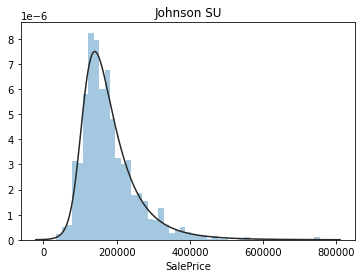

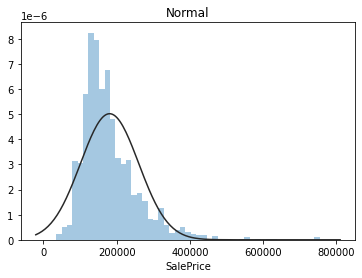

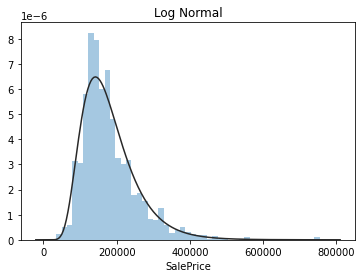

In [132]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [133]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']


test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(normal)

MSSubClass       True
LotFrontage      True
LotArea          True
OverallQual      True
OverallCond      True
YearBuilt        True
YearRemodAdd     True
MasVnrArea       True
BsmtFinSF1       True
BsmtFinSF2       True
BsmtUnfSF        True
TotalBsmtSF      True
1stFlrSF         True
2ndFlrSF         True
LowQualFinSF     True
GrLivArea        True
BsmtFullBath     True
BsmtHalfBath     True
FullBath         True
HalfBath         True
BedroomAbvGr     True
KitchenAbvGr     True
TotRmsAbvGrd     True
Fireplaces       True
GarageYrBlt      True
GarageCars       True
GarageArea       True
WoodDeckSF       True
OpenPorchSF      True
EnclosedPorch    True
3SsnPorch        True
ScreenPorch      True
PoolArea         True
MiscVal          True
MoSold           True
YrSold           True
dtype: bool


In [134]:
'''
turn qualitative features to  quantitative things by implementing encode function
sort one feature according to the mean price in each type and use 1:n to replace them 
'''

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

'''
show the spearman correlation among all features
'''

def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
#spearman(train, features)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [135]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

#delete 2 samples which has significantly high number for GrLivArea
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
#transform the price to normal distribution
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [137]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["PoolQC"] = features["PoolQC"].fillna("None")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [138]:
objects = [f for f in features.columns if features.dtypes[f] == 'object']
features.update(features[objects].fillna('None'))
'''
they think the length to the nearest street will be affected by the neighborhood of the house
so they group samples by the neighborhood then fill the na in 'LotFrontage' 
'''
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


numerics =[f for f in features.columns if features.dtypes[f] != 'object']
features.update(features[numerics].fillna(0))

In [139]:
'''
calculate skewness among all numeric features, and select that with high skewness level(>0.5)
'''

skew_features = features[numerics].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

#transform all these features to normal distribution using box cox
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [141]:
#delete 3 features, I don't know why....
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

#create new humanmade features in 2 ways. The first one is add some related features together, while the other is 1 or 0 for some features
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

#simply get one-hot encode
final_features = pd.get_dummies(features).reset_index(drop=True)

KeyError: "['Utilities' 'Street' 'PoolQC'] not found in axis"

In [142]:
'''
transfrom all features together, won't it cause the data leakage???
'''
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1458, 377), (1458,), (1459, 377))

In [84]:
#delete some samples for unknown reason
outliers = [30, 88, 462, 631, 1322]

X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

#count the most frequnt values in each feature, then delete them. However, I don't know the reason for the number 99.94.
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

In [143]:
X.shape, y.shape, X_sub.shape

((1458, 377), (1458,), (1459, 377))

In [104]:
h2o.init()
hf = h2o.H2OFrame(pd.concat([X, y], axis=1))
x_test_hf = h2o.H2OFrame(X_sub)
predictors = hf.drop('SalePrice').columns
response = 'SalePrice'
aml = H2OAutoML(
    max_models=50,
)
aml.train(x=predictors,y=response,training_frame=hf)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 8 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.4
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_unknownUser_zloyri
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.660 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
12:51:14.715: _train param, Dropping bad and constant columns: [SaleType_None, MSZoning_None, Exterior1st_None, Functional_None, KitchenQual_None, Exterior2nd_None]

█
12:51:19.873: _train param, Dropping bad and constant columns: [SaleType_None, MSZoning_None, Exterior1st_None, Functional_None, KitchenQual_None, Exterior2nd_None]

█
12:51:22.369: _train param, Dropping bad and constant columns: [SaleType_None, MSZoning_None, Exterior1st_None, Functional_None, KitchenQual_None, Exterior2nd_None]

████
12:51:34.603: _train param, Dropping bad and constant columns: [SaleType_None, MSZoning_None, Exterior1st_None, Functional_None, KitchenQual_None, Exterior2nd_None]


12:51:39.33: _train param, Dropping bad and constant columns: [SaleType_None, MSZoning_None, Exterior1st_None, Functi

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.075227,0.004858,0.071275,0.077098,0.077476,0.081067,0.069218
1,mean_residual_deviance,0.012325,0.003229,0.009962,0.011323,0.013796,0.017218,0.009324
2,mse,0.012325,0.003229,0.009962,0.011323,0.013796,0.017218,0.009324
3,null_deviance,46.618237,4.271526,45.297657,53.251472,41.583730,45.516083,47.442250
4,r2,0.922534,0.019797,0.934621,0.935235,0.900823,0.901194,0.940798
5,residual_deviance,3.555267,0.726245,2.958718,3.419578,4.097450,4.493923,2.806664
6,rmse,0.110292,0.014165,0.099810,0.106410,0.117457,0.131218,0.096563
7,rmsle,0.008610,0.001253,0.007763,0.008145,0.009232,0.010493,0.007418


In [114]:
submission_results = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
def top_k_avg_predict(k,leaderboard):
    lb=leaderboard.as_data_frame()
    ans=np.zeros((submission_results.shape[0],))

    for i in range(k):
        model=lb.loc[i]['model_id']
        print(model)
        pred=h2o.get_model(model).predict(x_test_hf)
        pred=pred.as_data_frame()
        ans+=np.floor(np.expm1(np.array(pred['predict'])))/k
    return ans


submission_results.iloc[:, 1]=(top_k_avg_predict(1,aml.leaderboard))
submission_results.head()
submission_results.to_csv('./submission.csv', index=False)

StackedEnsemble_AllModels_1_AutoML_4_20220914_125114
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
StackedEnsemble_BestOfFamily_1_AutoML_4_20220914_125114
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
GLM_1_AutoML_4_20220914_125114
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
GBM_grid_1_AutoML_4_20220914_125114_model_1
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
GBM_grid_1_AutoML_4_20220914_125114_model_2
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
GBM_grid_1_AutoML_4_20220914_125114_model_8
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
GBM_grid_1_AutoML_4_20220914_125114_model_6
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
GBM_2_AutoML_4_2022

In [116]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)   
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [144]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[14:18:46] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:17] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:48] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:19] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:49] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fract

In [145]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.05856813414010707


In [146]:
print('Predict submission')
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))
submission.head()

Predict submission


,Id,SalePrice
0,1461,62240.0
1,1462,73010.0
2,1463,84208.0
3,1464,89758.0
4,1465,81203.0


0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1453    175000.0
1454    210000.0
1455    266500.0
1456    142125.0
1457    147500.0
Name: SalePrice, Length: 1458, dtype: float64


array([207139.91150736, 187822.52327587, 216113.22938869, ...,
       263728.59165431, 142917.91722745, 148114.77747974])